In [50]:
import math

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager

from base.timeutil import YearMonth
from core.repository import FinanceLoader
from core.repository.maria.conn import maria_home

# 월 차트 로드
print("Fetching month chart...")

begin = YearMonth(2012, 3)
end = YearMonth(2023, 7)

month_chart = pd.read_sql(
    f"""
    select month_chart.*, stock.name, stock.exchange from month_chart
    join stock on month_chart.code = stock.code
    """,
    maria_home()
)

print("Loading financial data...")
fin_loader = FinanceLoader()

# matplot 셋업
font_path = './res/font/Gothic_A1/GothicA1-Medium.ttf'
font_manager.fontManager.addfont(font_path)
font_name = font_manager.fontManager.ttflist[-1].name

plt.rc("font", family=font_name)
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

Fetching month chart...
Loading financial data...


In [51]:
import pandas as pd
from base.timeutil import YearMonth, YearQuarter

month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
layer1 = pd.DataFrame()
yms = list(begin.to(end))
yms = pd.Series([ym for ym in yms if ym.month in [3, 5, 8, 11]] + [max(yms)])
# yms = pd.Series(yms)
yms = yms.drop_duplicates().sort_values()

for ym1, ym2 in [(ym.iloc[0], ym.iloc[1]) for ym in yms.rolling(2) if len(ym) == 2]:
    print(f"\r{ym1} {ym2}", end="\r")
    df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
    df2 = month_chart[month_chart["년월"] == ym2].set_index("code")
    df1 = df1[df1["val_last"] >= 1000_0000]
    df2.loc[df2["val_last"] == 0, "close"] = df2[df2["val_last"] == 0]["close"] / 2

    df = pd.DataFrame({
        "종목명": df1["name"], "거래소": df1["exchange"],
        "매수년월": ym1, "매도년월": ym2,
        "매수일": df1["date"], "매수가": df1["close"],
        "시가총액": df1["cap"], "거래량": df1["vol"], "거래대금": df1["val"],
        "전월수익률": df1["close"] / df1["open"] - 1
    })

    shares = pd.concat([df1["shares"], df2["shares"]], axis=1)
    df = df.loc[shares.max(axis=1) / shares.min(axis=1) < 1.5]  # 액면분할 제거

    df["매도가"] = df2["close"]
    df["매도일"] = df2["date"]
    df["수익률"] = df["매도가"] / df["매수가"] - 1
    # 재무데이터 조인하여 layer1에 반영
    fn = fin_loader.load(YearQuarter.last_confirmed(ym1.year, ym1.month))
    layer1 = pd.concat([layer1, df.join(fn)])

layer1.reset_index(inplace=True)
layer1

,code,종목명,거래소,매수년월,매도년월,매수일,매수가,시가총액,거래량,거래대금,...,O_QoQA,E_QoQA,R/A_QoQ,R/EQ_QoQ,GP/A_QoQ,GP/EQ_QoQ,O/A_QoQ,O/EQ_QoQ,E/A_QoQ,E/EQ_QoQ
0,060310,3S,코스닥,2012-03,2012-05,2012-03-30,20500,800753636500,5134684,107562943550,...,2.464625,3.949180,-0.031297,-0.202853,-0.005466,-0.049355,0.005344,-0.009380,0.014194,0.014303
1,006840,AK홀딩스,유가증권,2012-03,2012-05,2012-03-30,32000,284800000000,795205,25993983200,...,-0.452489,0.091971,0.005742,0.055238,-0.017596,-0.027063,-0.015163,-0.024840,-0.010560,-0.017450
2,054620,APS,코스닥,2012-03,2012-05,2012-03-30,13050,281637726750,11700595,157564423900,...,7.693141,6.161892,0.004313,0.215688,0.019232,0.068383,0.022591,0.057678,0.010280,0.026531
3,126600,BGF에코머티리얼즈,코스닥,2012-03,2012-05,2012-03-30,6400,55680000000,2093665,11663607660,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,138930,BNK금융지주,유가증권,2012-03,2012-05,2012-03-30,13300,2571952656700,14370897,200538992130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87068,189980,흥국에프엔비,코스닥,2023-05,2023-07,2023-05-31,2980,119610724460,13332212,38597749050,...,4.103340,-15.727934,-0.017821,0.039274,-0.006023,0.013537,0.005283,0.017027,0.002922,0.010228
87069,000540,흥국화재,유가증권,2023-05,2023-07,2023-05-31,3215,206540103675,1736470,5895496855,...,-5.708213,-12.721524,-0.004562,-1.129165,NaN,NaN,0.006684,-0.004460,0.005024,-0.006967
87070,003280,흥아해운,유가증권,2023-05,2023-07,2023-05-31,1352,325054463448,2157822,2935195108,...,1.387153,2.730592,0.044109,0.058857,0.028347,0.057952,0.020031,0.041599,0.018313,0.038572
87071,037440,희림,코스닥,2023-05,2023-07,2023-05-31,9190,127947545250,10837860,104127591920,...,-0.010596,0.989113,-0.023639,-0.011178,-0.002336,-0.000317,-0.002773,-0.005488,0.001033,0.004401


In [52]:
import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P",
        "거래대금": "TV",
    }
)

factors = [col for col in layer1.columns if "QoQ" in col and "QoQA" not in col]
factors += [
    "P",
    "EQ/P", "R/P", "GP/P", "O/P", "E/P",
    "R/A", "GP/A", "O/A", "E/A",
    "R/EQ", "GP/EQ", "O/EQ", "E/EQ",
]

layer2["EQ/P"] = layer2["EQ"] / layer2["P"]
layer2["R/P"] = layer2["R/Y"] / layer2["P"]
layer2["GP/P"] = layer2["GP/Y"] / layer2["P"]
layer2["O/P"] = layer2["O/Y"] / layer2["P"]
layer2["E/P"] = layer2["E/Y"] / layer2["P"]

layer2["R/A"] = layer2["R/Y"] / layer2["A"]
layer2["GP/A"] = layer2["GP/Y"] / layer2["A"]
layer2["O/A"] = layer2["O/Y"] / layer2["A"]
layer2["E/A"] = layer2["E/Y"] / layer2["A"]

layer2["R/EQ"] = layer2["R/Y"] / layer2["EQ"]
layer2["GP/EQ"] = layer2["GP/Y"] / layer2["EQ"]
layer2["O/EQ"] = layer2["O/Y"] / layer2["EQ"]
layer2["E/EQ"] = layer2["E/Y"] / layer2["EQ"]

recipes = {
    "벨류": {
        "EQ/P": 1,
        "GP/P": 1
    },
    "1/P": {"P": 1},
    "성장": {
        "GP/A_QoQ": 0.142706,
        "O/A_QoQ": 0.130182,
        "GP/EQ_QoQ": 0.129825,
        "O/EQ_QoQ": 0.118514,
        "E/EQ_QoQ": 0.111300,
        "O_QoQ": 0.098340,
        "E_QoQ": 0.097314,
        "GP_QoQ": 0.083276,
        "R/A_QoQ": 0.082624,
        "E/A_QoQ": 0.079270,
        "R/EQ_QoQ": 0.028347,
        "R_QoQ": 0.022196,
    },
    "전략": {
        "P": -1,
        "벨류": 1,
        "성장": 1
    }
}

result = pd.DataFrame()
yms = layer2["매도년월"].drop_duplicates().sort_values()
for ym in yms:
    print(f"\r{ym}", end="")
    df = layer2[layer2["매도년월"] == ym].copy()
    for factor in factors:
        df[f"{factor}_pct"] = np.ceil(df[factor].rank(method="min", pct=True) * 100)

    result = pd.concat([result, df])

    for title, recipe in recipes.items():
        # 1. 레시피를 구성하는 개별 팩터 분위(percentile) * 가중치의 총합을 구함
        sv = sum([df[f"{k}_pct"] * w if w > 0 else -df[f"{k}_pct"] * abs(w) for k, w in recipe.items()])

        # 2. 위의 시리즈에 가중치의 총합을 나눈다 => 0~1 사이 값으로 일반화됨
        df[title] = sv / sum([abs(w) for w in recipe.values()])
        df[f"{title}_pct"] = np.ceil(df[title].rank(method="min", pct=True) * 100)

    result = pd.concat([result, df])

result

2023-07

,code,종목명,거래소,매수년월,매도년월,매수일,매수가,P,거래량,TV,...,O/EQ_pct,E/EQ_pct,벨류,벨류_pct,1/P,1/P_pct,성장,성장_pct,전략,전략_pct
0,060310,3S,코스닥,2012-03,2012-05,2012-03-30,20500,800753636500,5134684,107562943550,...,49.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,006840,AK홀딩스,유가증권,2012-03,2012-05,2012-03-30,32000,284800000000,795205,25993983200,...,90.0,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,054620,APS,코스닥,2012-03,2012-05,2012-03-30,13050,281637726750,11700595,157564423900,...,52.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,126600,BGF에코머티리얼즈,코스닥,2012-03,2012-05,2012-03-30,6400,55680000000,2093665,11663607660,...,70.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,138930,BNK금융지주,유가증권,2012-03,2012-05,2012-03-30,13300,2571952656700,14370897,200538992130,...,93.0,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87068,189980,흥국에프엔비,코스닥,2023-05,2023-07,2023-05-31,2980,119610724460,13332212,38597749050,...,79.0,87.0,54.0,56.0,44.0,44.0,70.522281,75.0,29.000000,74.0
87069,000540,흥국화재,유가증권,2023-05,2023-07,2023-05-31,3215,206540103675,1736470,5895496855,...,88.0,86.0,51.5,53.0,62.0,62.0,NaN,NaN,NaN,NaN
87070,003280,흥아해운,유가증권,2023-05,2023-07,2023-05-31,1352,325054463448,2157822,2935195108,...,95.0,94.0,34.5,31.0,75.0,75.0,93.146923,98.0,18.000000,51.0
87071,037440,희림,코스닥,2023-05,2023-07,2023-05-31,9190,127947545250,10837860,104127591920,...,83.0,79.0,42.0,40.0,47.0,47.0,54.322147,56.0,16.333333,47.0


[4/4] 전략P2012-03 2023-07
            벨류  1/P        성장   전략
EQ/P       1.0  NaN       NaN  NaN
GP/P       1.0  NaN       NaN  NaN
P          NaN  1.0       NaN -1.0
GP/A_QoQ   NaN  NaN  0.142706  NaN
O/A_QoQ    NaN  NaN  0.130182  NaN
GP/EQ_QoQ  NaN  NaN  0.129825  NaN
O/EQ_QoQ   NaN  NaN  0.118514  NaN
E/EQ_QoQ   NaN  NaN  0.111300  NaN
O_QoQ      NaN  NaN  0.098340  NaN
E_QoQ      NaN  NaN  0.097314  NaN
GP_QoQ     NaN  NaN  0.083276  NaN
R/A_QoQ    NaN  NaN  0.082624  NaN
E/A_QoQ    NaN  NaN  0.079270  NaN
R/EQ_QoQ   NaN  NaN  0.028347  NaN
R_QoQ      NaN  NaN  0.022196  NaN
벨류         NaN  NaN       NaN  1.0
성장         NaN  NaN       NaN  1.0


,spearman,kendall,h3,h5,h10,t3,t5,t10,mdd5,h3-t3,h10-t10,h3-t3+mdd3,h10-t10+mdd10,mean,median,strength
전략,0.937186,0.788687,0.389192,0.359502,0.319066,-0.120134,-0.109641,-0.077320,-0.235428,0.509326,0.396386,0.258137,0.153394,0.093448,0.075414,0.292987
성장,0.818506,0.624646,0.170493,0.195161,0.208185,-0.031389,-0.030236,0.001826,-0.337438,0.201882,0.206359,-0.118250,-0.107786,0.090799,0.079230,0.105506
벨류,0.764080,0.571313,0.130426,0.144777,0.158176,-0.029365,-0.043633,-0.028287,-0.429738,0.159791,0.186463,-0.266912,-0.217538,0.086821,0.099416,0.081397
1/P,-0.871395,-0.695354,-0.008085,-0.002412,-0.003242,0.269542,0.304632,0.311642,-0.412210,-0.277626,-0.314884,-0.672722,-0.763998,0.088605,0.047329,-0.190797


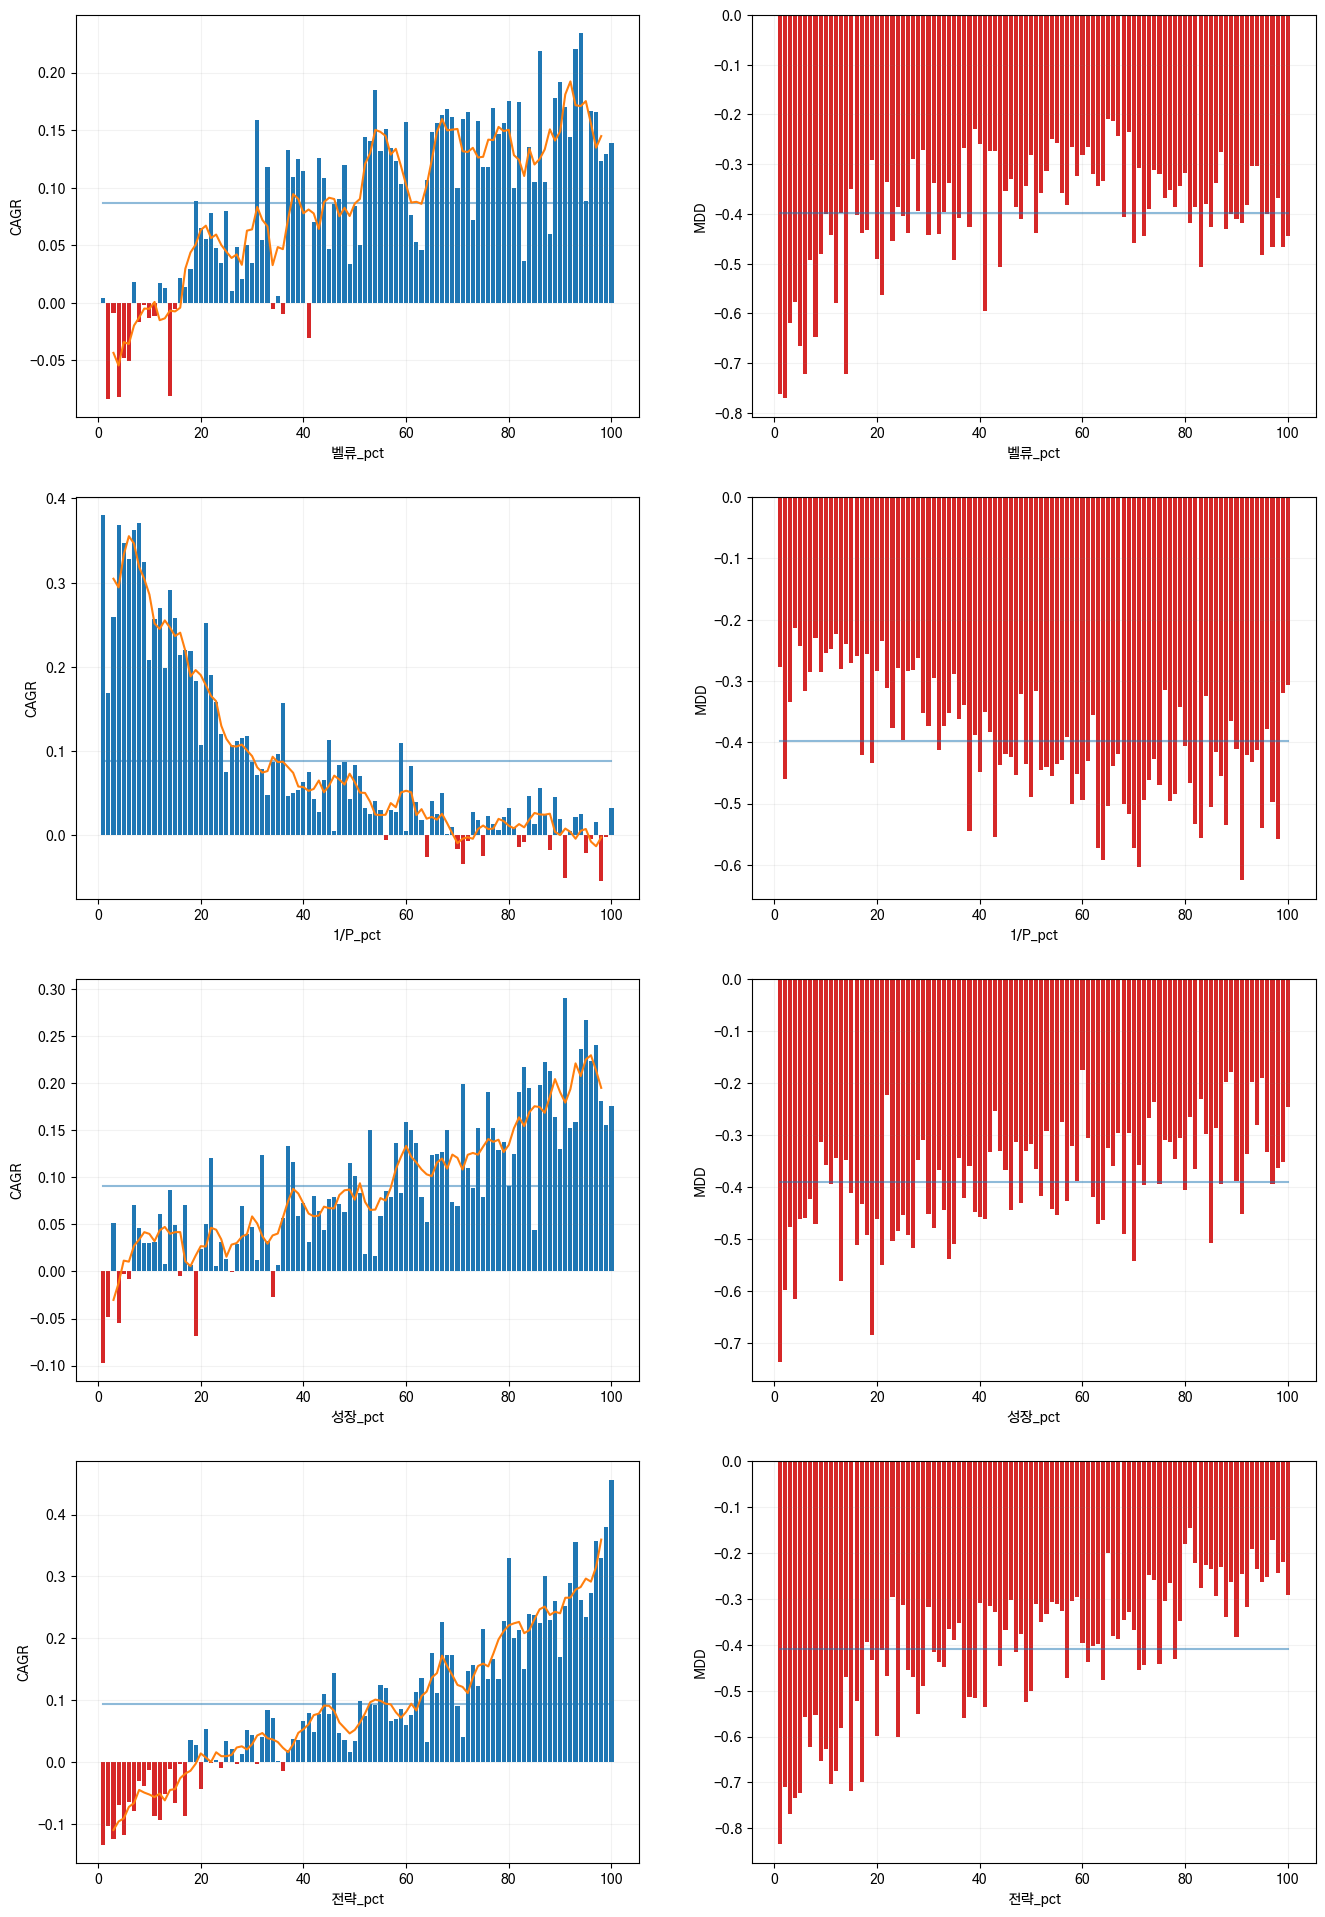

In [53]:
import matplotlib.pyplot as plt
from core.base.quantutil import cagr, mdd

target_factors = list(recipes.keys())
fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(16), fig.set_figheight(6 * len(target_factors))
summary = pd.DataFrame()
for i in range(len(target_factors)):
    factor = target_factors[i]
    print(f"\r[{i + 1}/{len(target_factors)}] {factor}", end="")
    colname = f"{factor}_pct"
    pcts = sorted(set(result[colname].dropna()))
    mean_by_pct = []
    cagr_by_pct = []
    mdd_by_pct = []
    for pct in pcts:
        by_pct = result[result[colname] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        cumprod = (return_by_ym + 1).cumprod()
        last = cumprod[-1]
        mean_by_pct.append(return_by_ym.mean())
        cagr_by_pct.append(cagr(1, last, by_pct["매수년월"].min().duration(by_pct["매도년월"].max())))
        dates = [s.last_date() for s in return_by_ym.index]
        mdd_by_pct.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]
    cagr_by_pct, mdd_by_pct = pd.Series(cagr_by_pct), pd.Series(mdd_by_pct)

    ax1.set_xlabel(colname)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(pd.Series(pcts), cagr_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_pct])
    ax1.plot(pd.Series(pcts), [cagr_by_pct.mean() for _ in pd.Series(pcts)], alpha=0.5)
    ax1.plot(pd.Series(pcts), cagr_by_pct.rolling(5, center=True).mean())

    ax2.set_xlabel(colname)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(pd.Series(pcts), mdd_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_pct])
    ax2.plot(pd.Series(pcts), [mdd_by_pct.mean() for _ in pd.Series(pcts)], alpha=0.5)

    spearman = pd.DataFrame({colname: pcts, "CAGR": cagr_by_pct}).corr(method="spearman")
    kendall = pd.DataFrame({colname: pcts, "CAGR": cagr_by_pct}).corr(method="kendall")
    cagr_by_pct_desc = cagr_by_pct[cagr_by_pct.index.sort_values(ascending=False)]
    mdd_by_pct_desc = mdd_by_pct[mdd_by_pct.index.sort_values(ascending=False)]
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": spearman[colname]["CAGR"],
            "kendall": kendall[colname]["CAGR"],
            "h3": cagr_by_pct_desc.head(3).mean(),
            "h5": cagr_by_pct_desc.head(5).mean(),
            "h10": cagr_by_pct_desc.head(10).mean(),
            "t3": cagr_by_pct_desc.tail(3).mean(),
            "t5": cagr_by_pct_desc.tail(5).mean(),
            "t10": cagr_by_pct_desc.tail(10).mean(),
            "mdd5": mdd_by_pct_desc.head(5).mean(),
            "h3-t3": cagr_by_pct_desc.head(3).mean() - cagr_by_pct_desc.tail(3).mean(),
            "h10-t10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean(),
            "h3-t3+mdd3": cagr_by_pct_desc.head(3).mean() - cagr_by_pct_desc.tail(3).mean() + mdd_by_pct_desc.head(
                3).mean(),
            "h10-t10+mdd10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean() + mdd_by_pct_desc.head(
                10).mean(),
            "mean": cagr_by_pct_desc.mean(),
            "median": cagr_by_pct_desc.median(),
        }).to_frame(factor).T
    ])
    summary["strength"] = summary["spearman"] * summary["kendall"] * summary["h10-t10"]

print(result["매수년월"].min(), result["매도년월"].max())
print(pd.DataFrame(recipes))
summary = summary.sort_values(by="strength", ascending=False)
summary

In [54]:
# 백테스트: 매매 시뮬레이션

from core.base.quantutil import cagr, mdd
from base.timeutil import YearMonth

_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "전략"
print(factor)

head = 20
result2 = result.copy()
result2 = result2[~result2["종목명"].str.endswith("홀딩스")]
result2 = result2[~result2["종목명"].str.endswith("지주")]
result2 = result2[result2["R/A_pct"] > 10]
result2 = result2[result2["GP/A_pct"] > 10]
result2 = result2[result2["O/A_pct"] > 10]
result2 = result2[result2["E/A_pct"] > 10]
result2 = result2[result2["R/EQ_pct"] > 10]
result2 = result2[result2["GP/EQ_pct"] > 10]
result2 = result2[result2["O/EQ_pct"] > 10]
result2 = result2[result2["E/EQ_pct"] > 10]

# todo: 필터를 전 종목 기준으로 하지말고, 전략 내에서 해보자. 예를들면, 전월수익률

strategy = result2.groupby(_key).apply(
    lambda values: values.sort_values(factor, ascending=False).head(head)["수익률"].mean())
strategy = pd.Series(strategy, index=benchmark.index).fillna(0)

revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})

years = (end.value() - begin.value()) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"][-1], years), cagr(1, revisions["벤치마크 누적수익률"][-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions.index], revisions["전략 누적수익률"]),
            mdd([i2 for _, i2 in revisions.index], revisions["벤치마크 누적수익률"])],
    "Mean": [revisions["전략 수익률"].mean(), revisions["벤치마크 수익률"].mean()]
}, index=["전략", "벤치마크"])
print(summary)

result3 = result2.groupby(_key).apply(
    lambda x: x.sort_values(factor, ascending=False).head(head).sort_values("수익률", ascending=False))[
    ["code", "종목명", "수익률", "거래소", "매수일", "매도일", "매수가", "매도가", "전월수익률", "P_pct", "성장_pct", "벨류_pct", f"{factor}_pct"]]
result3.to_csv("result3-2.csv")
result3

전략
          CAGR                                        MDD      Mean
전략    0.434087  (-0.2964780928454248, (2019-11, 2020-03))  0.103949
벤치마크  0.095698   (-0.338253756921846, (2018-05, 2020-03))  0.027071


code        종목명       수익률   거래소         매수일  \
매수년월    매도년월                                                           
2012-03 2012-05 775    052460     아이크래프트  0.415094   코스닥  2012-03-30   
                1170   071950        코아스  0.239316  유가증권  2012-03-30   
                203    039240       경남스틸  0.191781   코스닥  2012-03-30   
                914    046940       우원개발  0.166113   코스닥  2012-03-30   
                1219   091440       텔레필드  0.135531   코스닥  2012-03-30   
...                       ...        ...       ...   ...         ...   
2023-05 2023-07 84731  044180         KD -0.130337   코스닥  2023-05-31   
                86526  001620  케이비아이동국실업 -0.133523  유가증권  2023-05-31   
                86494  009310     참엔지니어링 -0.157576  유가증권  2023-05-31   
                85290  900260        로스웰 -0.189216   코스닥  2023-05-31   
                85930  095910      에스에너지 -0.210526   코스닥  2023-05-31   

                              매도일   매수가     매도가     전월수익률  P_pct  성장_pct  \
매수년월    매도년월                                                               
2012-03 2012-05 775    2012-05-31  1590  2250.0 -0.061947    3.0    93.0   
                1170   2012-05-31  1170  1450.0 -0.235294   11.0    77.0   
                203    2012-05-31  6570  7830.0 -0.109756   19.0    98.0   
                914    2012-05-31  1505  1755.0 -0.135057    9.0    94.0   
                1219   2012-05-31  1365  1550.0 -0.096026    2.0    90.0   
...                           ...   ...     ...       ...    ...     ...   
2023-05 2023-07 84731  2023-07-31   890   774.0 -0.310078    4.0    98.0   
                86526  2023-07-31   704   610.0 -0.162901   26.0    93.0   
                86494  2023-07-31   660   556.0  0.044304    8.0    69.0   
                85290  2023-07-31  1020   827.0  0.034483    7.0    91.0   
                85930  2023-07-31  2755  2175.0 -0.029930   16.0    86.0   

                       벨류_pct  전략_pct  
매수년월    매도년월                           
2012-03 2012-05 775      93.0   100.0  
                1170     91.0    98.0  
                203      88.0   100.0  
                914      92.0   100.0  
                1219     96.0   100.0  
...                       ...     ...  
2023-05 2023-07 84731    87.0   100.0  
                86526    94.0   100.0  
                86494    94.0    99.0  
                85290    84.0   100.0  
                85930    89.0   100.0  

[920 rows x 13 columns]

전체 개월 수      46.000000
초과수익 개월 수    38.000000
누적 성능        25.875801
dtype: float64

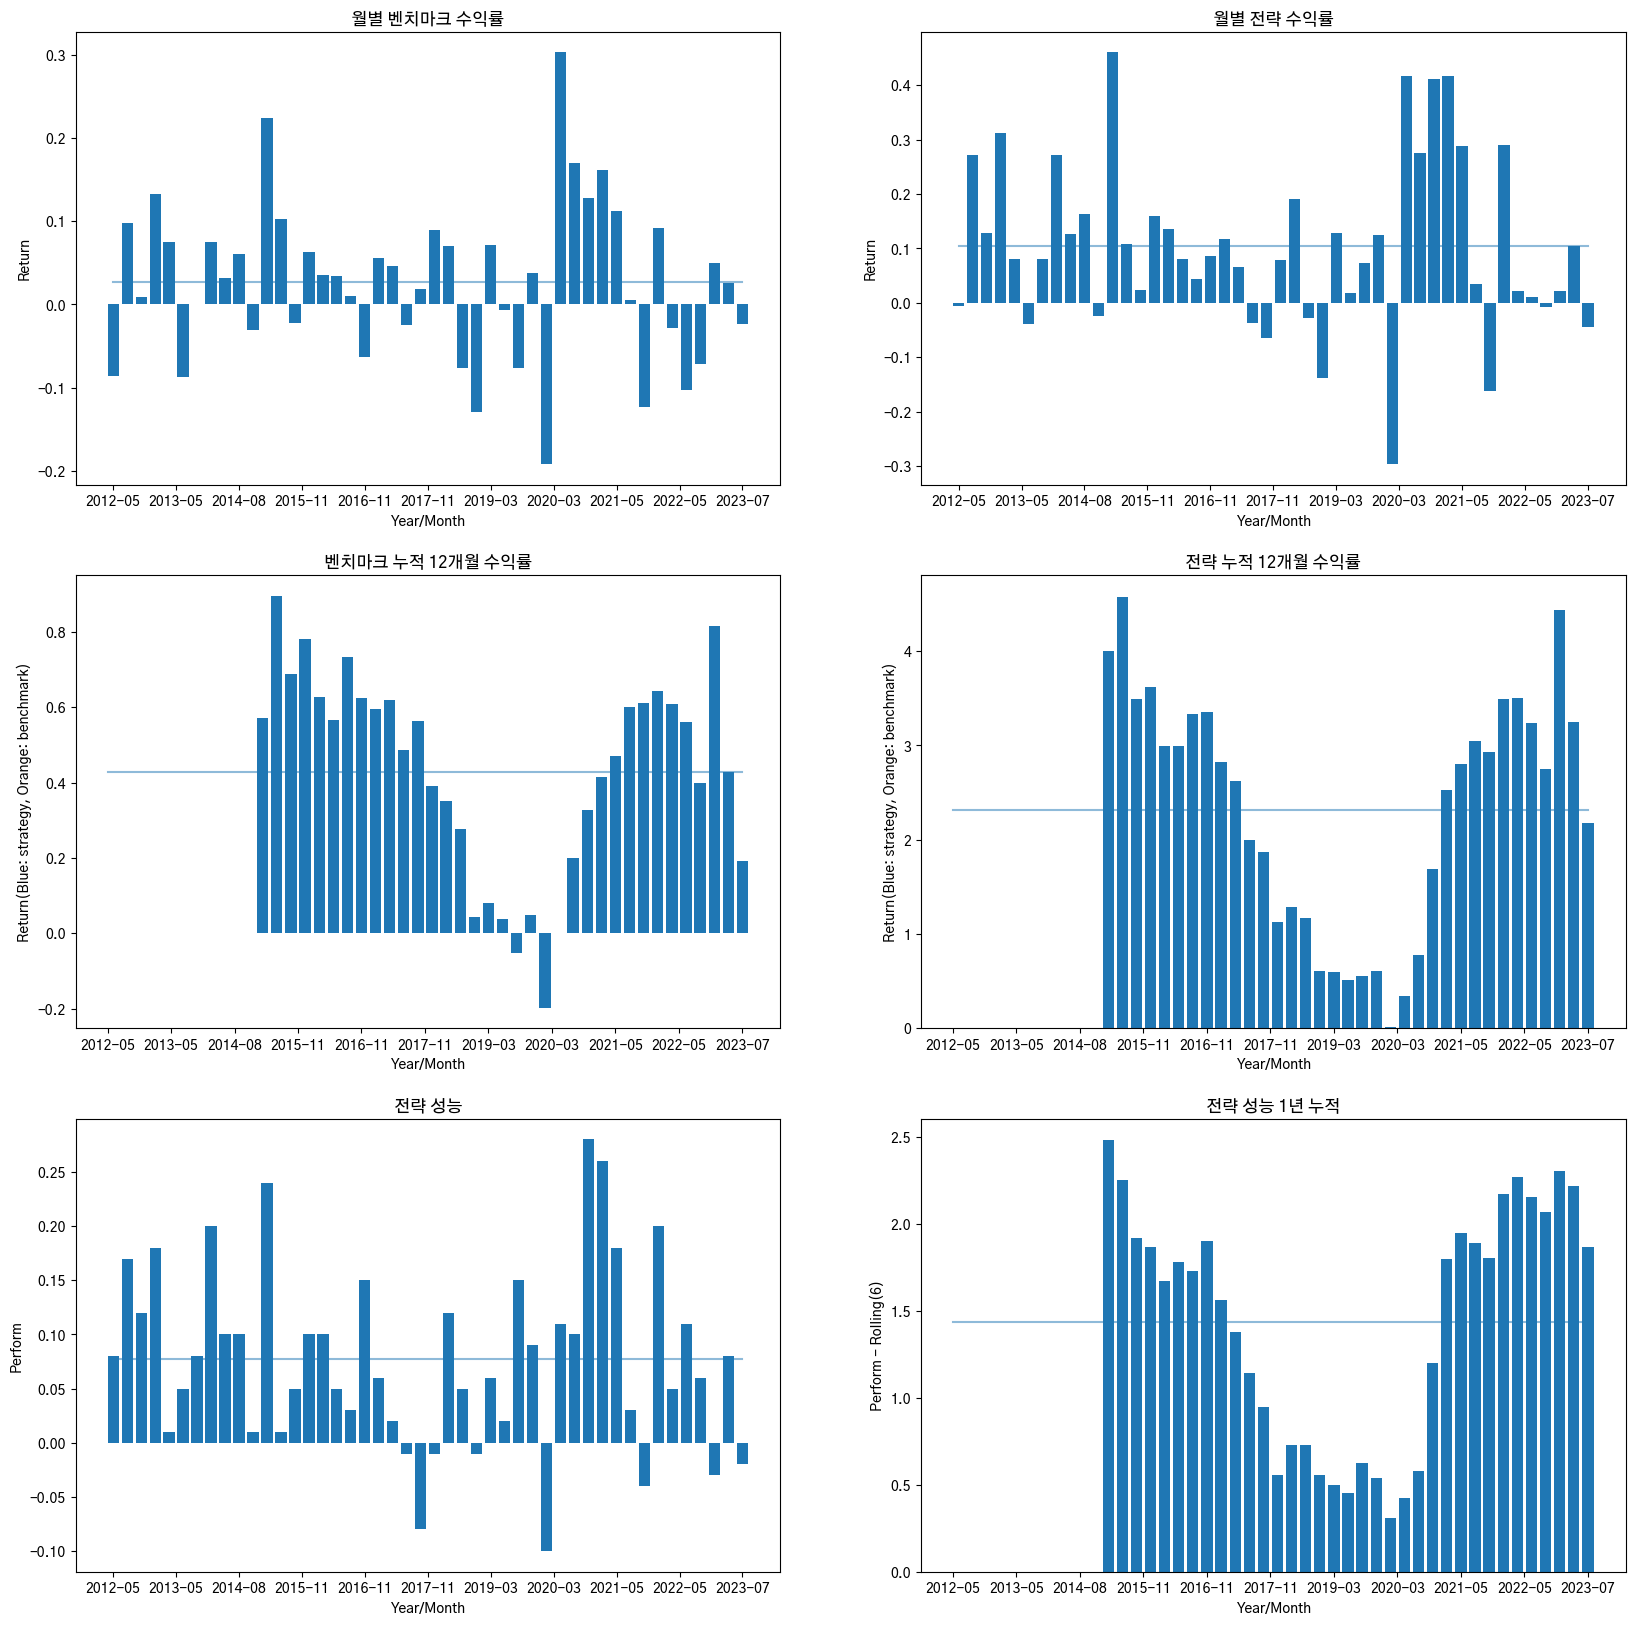

In [55]:
import numpy as np

months = [str(i) for _, i in strategy.index]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"월별 벤치마크 수익률")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["벤치마크 수익률"])
ax1.plot(months, [revisions["벤치마크 수익률"].mean()] * len(months), alpha=0.5)

ax2.set_title("월별 전략 수익률")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["전략 수익률"])
ax2.plot(months, [revisions["전략 수익률"].mean()] * len(months), alpha=0.5)

ax3.set_title(f"벤치마크 누적 12개월 수익률")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["벤치마크 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax3.bar(months, values)
ax3.plot(months, [values.mean()] * len(months), alpha=0.5)

ax4.set_title("전략 누적 12개월 수익률")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["전략 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax4.bar(months, values)
ax4.plot(months, [values.mean()] * len(months), alpha=0.5)

ax5.set_title("전략 성능")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["성능"])
ax5.plot(months, [revisions["성능"].mean()] * len(months), alpha=0.5)

ax6.set_title(f"전략 성능 1년 누적")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({6})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["성능"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax6.bar(months, values)
ax6.plot(months, [values.mean()] * len(months), alpha=0.5)

pd.Series({
    "전체 개월 수": len(revisions),
    "초과수익 개월 수": len(revisions[revisions["성능"] > 0]),
    "누적 성능": (revisions["성능"] + 1).prod() - 1,
})